# G Lookup Table in numpy

TODO: 
- add multi-resolution option
- test optimal size (performance vs accuracy)

In [1]:
from scipy.special import hyp1f1
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def hyp_der_approx(a, b, z, eps=10e-10):
    left_approx  = ( hyp1f1(a, b, z) - hyp1f1(a - eps, b, z) ) / eps
    return left_approx

## 1. G Sampling

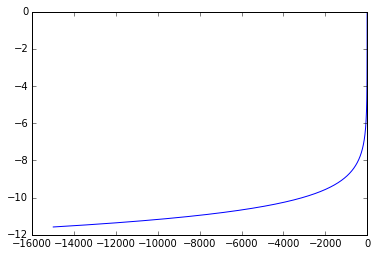

In [3]:
res = 10000
X = np.geomspace(-15000, -1, res) + 1
Y = np.array([hyp_der_approx(0, 0.5, i) for i in X])

plt.plot(X, Y)
plt.show()

In [4]:
table = np.array([X, Y])

In [5]:
np.save('g_lookup_table', table)

## 2. Numpy Lookup Table

In [6]:
def table_lookup(table, key):
    # index from table value with closest table_key to given key
    table_ind = np.argmin( np.abs(table[0] - key) )
    
    # difference from closest table_key to given key
    shift     = key - table[0, table_ind]
    
    # -1 if table_ind == 0, 1 if table_ind > 0 (table ind always >= 0)
    ti_zero_indicator =  - np.sign((1 - np.sign(table_ind)) - .5) 
    
    # shift to next table entry (used for gradient computation)
    # if table_key == key:
    # if key != 0 : next smaller table_key is used
    # if key == 0 : next greater table_key is used
    nonzero_shift = (1 - np.sign(np.absolute(shift))) * (-1. * ti_zero_indicator) + shift
    
    shift_step = np.int(np.sign(nonzero_shift)) 
    table_ind_shifted = table_ind + shift_step
    
    table_val = table[1,table_ind]
    next_table_val = table[1, table_ind_shifted]
    
    table_key = table[0, table_ind]
    next_table_key = table[0, table_ind_shifted]
    
    dx = (next_table_key - table_key)
    dy = (next_table_val - table_val)
    
    gradient               = dy / dx
    interpolated_fun_value = table_val + shift * gradient
    
    return interpolated_fun_value, gradient

### Test: Sin Function

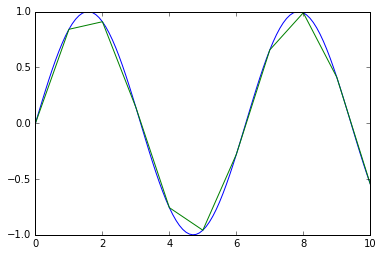

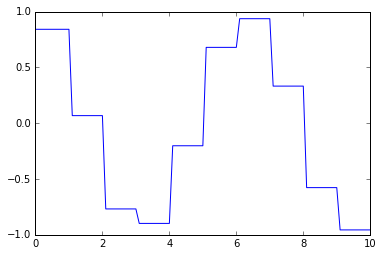

In [7]:
sin_x = np.linspace(0, 10, 11)
sin_y = np.sin(sin_x)
sin_table = np.array([sin_x, sin_y])

grid = np.linspace(0, 10, 101)
vals_grads = np.array([table_lookup(sin_table, x) for x in grid])

plt.plot(grid, np.sin(grid))
plt.plot(grid, vals_grads[:,0])
plt.show()

plt.plot(grid, vals_grads[:,1])
plt.show()

## 3. Tensorflow Lookup Table

In [8]:
def table_lookup_op(table, key):
    # single-lookup only!
    
    # index from table value with closest table_key to given key
    table_ind = tf.argmin( tf.abs(table[0] - key) , output_type=tf.int32)
    
    # difference from closest table_key to given key
    shift     = key - table[0, table_ind]
    
    # -1 if table_ind == 0, 1 if table_ind > 0 (table ind always >= 0)
    ti_zero_indicator = - tf.sign( tf.cast(tf.subtract(1, tf.sign(table_ind)), dtype=tf.float32) - tf.constant(.5))
    
    # shift to next table entry (used for gradient computation)
    # if table_key == key:
    # if key != 0 : next smaller table_key is used
    # if key == 0 : next greater table_key is used
    nonzero_shift = (1 - tf.sign(tf.abs(shift))) * (-1. * ti_zero_indicator) + shift
    
    shift_step = tf.cast(tf.sign(nonzero_shift), tf.int32) 
    table_ind_shifted = table_ind + shift_step
    
    table_val = table[1,table_ind]
    next_table_val = table[1, table_ind_shifted]
    
    table_key = table[0, table_ind]
    next_table_key = table[0, table_ind_shifted]
    
    dx = (next_table_key - table_key)
    dy = (next_table_val - table_val)
    
    gradient               = dy / dx
    interpolated_fun_value = table_val + shift * gradient
    
    return tf.stop_gradient(gradient) * key + tf.stop_gradient(interpolated_fun_value - gradient * key) 

In [61]:
def table_lookup_op_parallel(table, keys):
    '''
    Remark: this one handles edge cases correctly
    '''
    
    table_keys = table[0]
    table_vals = table[1]
    
    num_keys = tf.shape(keys)[0]
    
    # index from table value with closest table_key to given key
    table_ind = tf.argmin( tf.abs(tf.expand_dims(table_keys, 0) - tf.expand_dims(keys, 1) ) , output_type=tf.int32, axis=1)
    
    top_keys = tf.gather(table_keys, table_ind)
    
    # difference from closest table_key to given key
    shift     = keys - top_keys

    # out of bounds switch on the left
    table_min_key = table_keys[0]
    oob_l_switch  = tf.sign(tf.sign( keys - table_min_key) - 0.5)
    # out of bounds switch on the right
    table_max_key = table_keys[tf.shape(table)[1] - 1]
    oob_r_switch  = -1 * tf.sign(tf.sign( keys - table_max_key ) - 0.5)
    
    # real shift or shift to the smaller key if shift == 0
    nonzero_shift = (tf.sign(tf.abs(shift)) - 1)  + shift
    # shift to the right if table_ind is 0
    # adapted_shift = nonzero_shift * (-1 * ti_zero_indicator) 
    adapted_shift = nonzero_shift * oob_l_switch
    # shift to the left if key > max_key
    adapted_shift = adapted_shift * oob_r_switch
    
    # either -1 or 1, direction to the second table entry used for gradient calculation
    next_entry_shift = tf.cast(tf.sign(adapted_shift), tf.int32) 
    
    table_ind_shifted = table_ind + next_entry_shift
    
    table_val      = tf.gather(table_vals, table_ind)
    next_table_val = tf.gather(table_vals, table_ind_shifted)
    
    table_key      = tf.gather(table_keys, table_ind)
    next_table_key = tf.gather(table_keys, table_ind_shifted)
    
    dx = (next_table_key - table_key)
    dy = (next_table_val - table_val)
    
    gradient               = dy / dx
    interpolated_fun_value = table_val + shift * gradient
    
    return tf.stop_gradient(gradient) * keys + tf.stop_gradient(interpolated_fun_value - gradient * keys)

### Parallel Lookup Table

lookup table:
[[0 1 2]
 [1 0 2]]
interpolated values:
test_v: [-0.5  0.   0.5  1.   1.5  2.   2.5]
values: [ 1.5  1.   0.5  0.   1.   2.   3. ]
grads : [-1. -1. -1. -1.  2.  2.  2.]


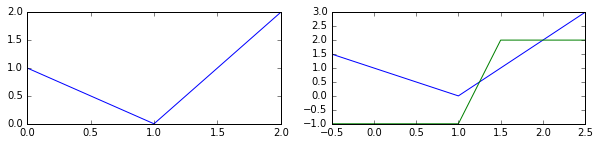

In [63]:
x_vals = np.array([0, 1, 2])
y_vals = np.array([1, 0, 2])
table = np.array([x_vals, y_vals])

test_values     = np.array([-0.5, 0,0.5,1, 1.5, 2, 2.5])

tf_table = tf.convert_to_tensor(table, dtype=tf.float32)

input_x = tf.placeholder(tf.float32, shape=[None])

table_values = table_lookup_op_parallel(tf_table, input_x)
table_grads  = tf.gradients(table_values, [input_x])

with tf.Session() as sess:
    
     tf_vals, tf_grads = sess.run([table_values, table_grads[0]], feed_dict={input_x:test_values})

print('lookup table:')    
print(table)    

print('interpolated values:')
print('test_v: {}'.format(test_values))
print('values: {}'.format(tf_vals))
print('grads : {}'.format(tf_grads))

plt.figure(figsize=(10, 2))
plt.subplot(1,2,1)
plt.plot(table[0], table[1])

plt.subplot(1,2,2)
plt.plot(test_values, tf_vals)
plt.plot(test_values, tf_grads)

plt.show()